In [1]:
"""
EMAIL SPAM DETECTION USING NLP AND MACHINE LEARNING
====================================================
Team 10: Rutwik Ganagi & Dennis Sharon
Northeastern University

This notebook implements a complete email spam detection system using:
- Natural Language Processing (NLP) techniques
- Multiple Machine Learning algorithms
- Comprehensive evaluation metrics
"""

# =============================================================================
# PART 1: IMPORT LIBRARIES AND SETUP
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)

# Download required NLTK data
print("Downloading required NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print("="*80)

All libraries imported successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rutwikganagi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rutwikganagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rutwikganagi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rutwikganagi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rutwikganagi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rutwikganagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rutwikganagi/nltk_data...
[nltk_data]   Package wordnet 

In [2]:
# =============================================================================
# PART 2: DATA LOADING
# =============================================================================

print("\n" + "="*80)
print("PART 2: DATA LOADING")
print("="*80)

"""
The Phishing Email Dataset contains multiple CSV files from different sources:
- CEAS_08.csv: CEAS 2008 spam corpus
- Enron.csv: Enron legitimate emails
- Ling.csv: Ling-Spam dataset
- Nazario.csv: Nazario phishing corpus
- Nigerian_Fraud.csv: Nigerian fraud emails
- SpamAssasin.csv: SpamAssassin corpus

We'll load and combine all these files.
"""

def load_and_standardize_dataset(file_paths):
    """Load dataset and standardize column names"""
    dataframes = []
    
    for file_path in file_paths:
        try:
            # Try UTF-8 first
            df_temp = pd.read_csv(file_path, encoding='utf-8')
            print(f"✓ Loaded {file_path}: {len(df_temp)} emails")
            print(f"  Columns: {df_temp.columns.tolist()}")
            dataframes.append(df_temp)
        except UnicodeDecodeError:
            # Try latin-1
            df_temp = pd.read_csv(file_path, encoding='latin-1')
            print(f"✓ Loaded {file_path} (latin-1): {len(df_temp)} emails")
            print(f"  Columns: {df_temp.columns.tolist()}")
            dataframes.append(df_temp)
        except Exception as e:
            print(f"✗ Error loading {file_path}: {e}")
    
    if not dataframes:
        return None
    
    # Combine all dataframes
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    # Standardize column names
    print("\n" + "="*60)
    print("STANDARDIZING COLUMN NAMES")
    print("="*60)
    
    # Check for common column name variations
    # For label column
    label_columns = ['label', 'Label', 'class', 'Class', 'spam', 'Spam', 'type']
    body_columns = ['body', 'Body', 'text', 'Text', 'message', 'Message', 'content', 'email']
    subject_columns = ['subject', 'Subject', 'title', 'Title']
    
    # Find and rename label column
    for col in combined_df.columns:
        if col.lower() in [c.lower() for c in label_columns]:
            combined_df.rename(columns={col: 'label'}, inplace=True)
            print(f"✓ Renamed '{col}' → 'label'")
            break
    
    # Find and rename body column
    for col in combined_df.columns:
        if col.lower() in [c.lower() for c in body_columns]:
            combined_df.rename(columns={col: 'body'}, inplace=True)
            print(f"✓ Renamed '{col}' → 'body'")
            break
    
    # Find and rename subject column
    for col in combined_df.columns:
        if col.lower() in [c.lower() for c in subject_columns]:
            combined_df.rename(columns={col: 'subject'}, inplace=True)
            print(f"✓ Renamed '{col}' → 'subject'")
            break
    
    # Ensure label is binary (0 and 1)
    if 'label' in combined_df.columns:
        unique_labels = combined_df['label'].unique()
        print(f"\nUnique label values: {unique_labels}")
        
        # Convert labels to 0 and 1 if needed
        if set(unique_labels) == {0, 1}:
            print("✓ Labels are already binary (0, 1)")
        elif set(unique_labels) == {'ham', 'spam'}:
            combined_df['label'] = combined_df['label'].map({'ham': 0, 'spam': 1})
            print("✓ Converted 'ham'→0, 'spam'→1")
        elif set(unique_labels) == {'Ham', 'Spam'}:
            combined_df['label'] = combined_df['label'].map({'Ham': 0, 'Spam': 1})
            print("✓ Converted 'Ham'→0, 'Spam'→1")
        elif set(unique_labels) == {'legitimate', 'phishing'}:
            combined_df['label'] = combined_df['label'].map({'legitimate': 0, 'phishing': 1})
            print("✓ Converted 'legitimate'→0, 'phishing'→1")
    
    print(f"\n✓ Final columns: {combined_df.columns.tolist()}")
    print(f"✓ Total emails: {len(combined_df)}")
    
    return combined_df

file_paths = [
    'data/CEAS_08.csv',
    'data/Enron.csv',
    'data/Ling.csv',
    'data/Nazario.csv',
    'data/Nigerian_Fraud.csv',
    'data/SpamAssasin.csv'
]

# Load the dataset
df = load_and_standardize_dataset(file_paths)


# Display basic information
print("\nDataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())



print("\n4. Label distribution:")
print(df['label'].value_counts())
print(f"\nSpam (1): {sum(df['label']==1)}")
print(f"Ham (0): {sum(df['label']==0)}")

print("\n5. Sample spam emails:")
spam_samples = df[df['label']==1].head(3)
for idx, row in spam_samples.iterrows():
    print(f"\nSpam example {idx}:")
    print(f"Body: {str(row['body'])[:100]}...")

print("\n6. Sample ham emails:")
ham_samples = df[df['label']==0].head(3)
for idx, row in ham_samples.iterrows():
    print(f"\nHam example {idx}:")
    print(f"Body: {str(row['body'])[:100]}...")


PART 2: DATA LOADING
✓ Loaded data/CEAS_08.csv: 39154 emails
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
✓ Loaded data/Enron.csv: 29767 emails
  Columns: ['subject', 'body', 'label']
✓ Loaded data/Ling.csv: 2859 emails
  Columns: ['subject', 'body', 'label']
✓ Loaded data/Nazario.csv: 1565 emails
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
✓ Loaded data/Nigerian_Fraud.csv: 3332 emails
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
✓ Loaded data/SpamAssasin.csv: 5809 emails
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']

STANDARDIZING COLUMN NAMES
✓ Renamed 'label' → 'label'
✓ Renamed 'body' → 'body'
✓ Renamed 'subject' → 'subject'

Unique label values: [1 0]
✓ Labels are already binary (0, 1)

✓ Final columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
✓ Total emails: 82486

Dataset Shape: (82486, 7)

Column Names: ['sender', 'receiv


PART 3: EXPLORATORY DATA ANALYSIS

--- Dataset Overview ---
Total Emails: 82486
Features: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']

Data Types:
sender       object
receiver     object
date         object
subject      object
body         object
label         int64
urls        float64
dtype: object

--- Missing Values ---
sender      32957
receiver    34718
date        33109
subject       347
body            1
urls        32626
dtype: int64

--- Label Distribution ---
label
1    42891
0    39595
Name: count, dtype: int64

Spam Percentage: 52.00%
Ham Percentage: 48.00%

--- Data Split Check ---
Spam emails: 42891
Ham emails: 39595

--- Statistics ---
Spam - Avg Length: 1391 chars, Avg Words: 195
Ham  - Avg Length: 2161 chars, Avg Words: 357


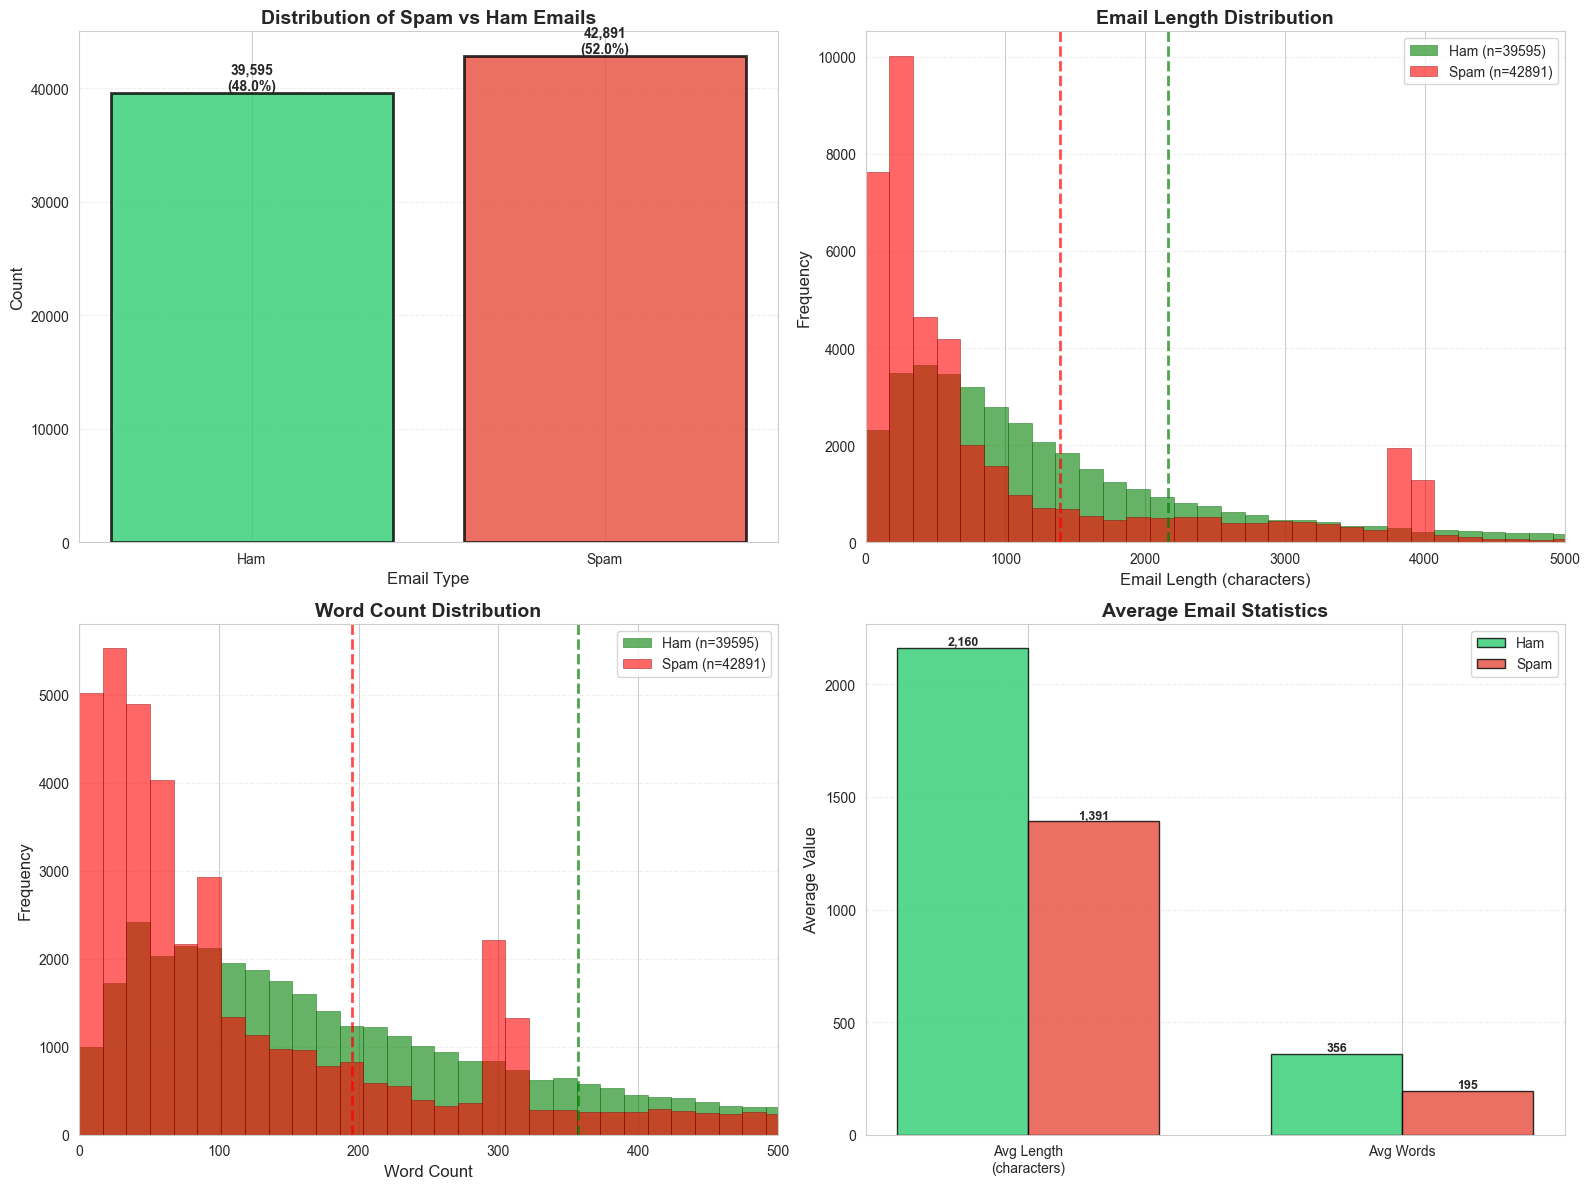


✓ EDA visualizations saved as 'eda_analysis.png'


In [3]:
# =============================================================================
# PART 3: DATA EXPLORATION AND ANALYSIS (EDA)
# =============================================================================

print("\n" + "="*80)
print("PART 3: EXPLORATORY DATA ANALYSIS")
print("="*80)

def explore_dataset(df):
    """
    Perform comprehensive exploratory data analysis
    
    Parameters:
    -----------
    df : pd.DataFrame
        The email dataset
    """
    print("\n--- Dataset Overview ---")
    print(f"Total Emails: {len(df)}")
    print(f"Features: {df.columns.tolist()}")
    print(f"\nData Types:\n{df.dtypes}")
    
    print("\n--- Missing Values ---")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("No missing values found!")
    
    print("\n--- Label Distribution ---")
    label_counts = df['label'].value_counts()
    print(label_counts)
    print(f"\nSpam Percentage: {(label_counts[1]/len(df))*100:.2f}%")
    print(f"Ham Percentage: {(label_counts[0]/len(df))*100:.2f}%")
    
    # Create features for analysis
    df['email_length'] = df['body'].astype(str).apply(len)
    df['word_count'] = df['body'].astype(str).apply(lambda x: len(x.split()))
    
    # Separate data by label
    spam_df = df[df['label'] == 1].copy()
    ham_df = df[df['label'] == 0].copy()
    
    print(f"\n--- Data Split Check ---")
    print(f"Spam emails: {len(spam_df)}")
    print(f"Ham emails: {len(ham_df)}")
    
    # Check if we have both classes
    if len(spam_df) == 0:
        print("\n⚠️ WARNING: No spam emails found!")
        print("Cannot create comparison plots.")
        return df
    
    if len(ham_df) == 0:
        print("\n⚠️ WARNING: No ham emails found!")
        print("Cannot create comparison plots.")
        return df
    
    # Get statistics
    spam_lengths = spam_df['email_length']
    ham_lengths = ham_df['email_length']
    spam_words = spam_df['word_count']
    ham_words = ham_df['word_count']
    
    print(f"\n--- Statistics ---")
    print(f"Spam - Avg Length: {spam_lengths.mean():.0f} chars, Avg Words: {spam_words.mean():.0f}")
    print(f"Ham  - Avg Length: {ham_lengths.mean():.0f} chars, Avg Words: {ham_words.mean():.0f}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # =========================================================================
    # 1. Label Distribution (BAR CHART)
    # =========================================================================
    label_counts_sorted = label_counts.sort_index()
    bars = axes[0, 0].bar(['Ham', 'Spam'], label_counts_sorted.values, 
                          color=['#2ecc71', '#e74c3c'], alpha=0.8, 
                          edgecolor='black', linewidth=2)
    
    axes[0, 0].set_title('Distribution of Spam vs Ham Emails', 
                        fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Email Type', fontsize=12)
    axes[0, 0].set_ylabel('Count', fontsize=12)
    axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}\n({height/len(df)*100:.1f}%)',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # =========================================================================
    # 2. Email Length Distribution (HISTOGRAM)
    # =========================================================================
    # Calculate appropriate bins
    max_length = max(spam_lengths.max(), ham_lengths.max())
    # Limit to reasonable range and create bins
    bin_limit = min(max_length, 10000)
    bins = np.linspace(0, bin_limit, 60)
    
    # Plot histograms with proper separation
    axes[0, 1].hist(ham_lengths, bins=bins, alpha=0.6, 
                   label=f'Ham (n={len(ham_lengths)})', 
                   color='green', edgecolor='darkgreen', linewidth=0.5)
    axes[0, 1].hist(spam_lengths, bins=bins, alpha=0.6, 
                   label=f'Spam (n={len(spam_lengths)})', 
                   color='red', edgecolor='darkred', linewidth=0.5)
    
    axes[0, 1].set_title('Email Length Distribution', 
                        fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Email Length (characters)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].set_xlim(0, 5000)  # Focus on main range
    axes[0, 1].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add average lines
    axes[0, 1].axvline(ham_lengths.mean(), color='green', 
                      linestyle='--', linewidth=2, alpha=0.7,
                      label=f'Ham avg: {ham_lengths.mean():.0f}')
    axes[0, 1].axvline(spam_lengths.mean(), color='red', 
                      linestyle='--', linewidth=2, alpha=0.7,
                      label=f'Spam avg: {spam_lengths.mean():.0f}')
    
    # =========================================================================
    # 3. Word Count Distribution (HISTOGRAM)
    # =========================================================================
    # Calculate appropriate bins
    max_words = max(spam_words.max(), ham_words.max())
    bin_limit = min(max_words, 1000)
    bins = np.linspace(0, bin_limit, 60)
    
    # Plot histograms with proper separation
    axes[1, 0].hist(ham_words, bins=bins, alpha=0.6,
                   label=f'Ham (n={len(ham_words)})',
                   color='green', edgecolor='darkgreen', linewidth=0.5)
    axes[1, 0].hist(spam_words, bins=bins, alpha=0.6,
                   label=f'Spam (n={len(spam_words)})',
                   color='red', edgecolor='darkred', linewidth=0.5)
    
    axes[1, 0].set_title('Word Count Distribution', 
                        fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Word Count', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].set_xlim(0, 500)  # Focus on main range
    axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add average lines
    axes[1, 0].axvline(ham_words.mean(), color='green',
                      linestyle='--', linewidth=2, alpha=0.7,
                      label=f'Ham avg: {ham_words.mean():.0f}')
    axes[1, 0].axvline(spam_words.mean(), color='red',
                      linestyle='--', linewidth=2, alpha=0.7,
                      label=f'Spam avg: {spam_words.mean():.0f}')
    
    # =========================================================================
    # 4. Average Statistics (BAR CHART)
    # =========================================================================
    categories = ['Avg Length\n(characters)', 'Avg Words']
    ham_stats = [ham_lengths.mean(), ham_words.mean()]
    spam_stats = [spam_lengths.mean(), spam_words.mean()]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = axes[1, 1].bar(x - width/2, ham_stats, width, 
                          label='Ham', color='#2ecc71', 
                          alpha=0.8, edgecolor='black')
    bars2 = axes[1, 1].bar(x + width/2, spam_stats, width,
                          label='Spam', color='#e74c3c',
                          alpha=0.8, edgecolor='black')
    
    axes[1, 1].set_title('Average Email Statistics', 
                        fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Average Value', fontsize=12)
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(categories, fontsize=10)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                          f'{int(height):,}',
                          ha='center', va='bottom', 
                          fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ EDA visualizations saved as 'eda_analysis.png'")
    
    return df

# Execute the function
df = explore_dataset(df)

In [4]:
# =============================================================================
# PART 4: TEXT PREPROCESSING
# =============================================================================

print("\n" + "="*80)
print("PART 4: TEXT PREPROCESSING")
print("="*80)

class TextPreprocessor:
    """
    A comprehensive text preprocessing pipeline for email data
    """
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def clean_text(self, text):
        """
        Clean and preprocess a single text document
        
        Steps:
        1. Convert to lowercase
        2. Remove HTML tags
        3. Remove URLs
        4. Remove email addresses
        5. Remove special characters and digits
        6. Remove extra whitespace
        7. Tokenize
        8. Remove stopwords
        9. Lemmatize
        
        Parameters:
        -----------
        text : str
            Raw text to preprocess
            
        Returns:
        --------
        str
            Cleaned and preprocessed text
        """
        if pd.isna(text):
            return ""
        
        # Convert to string and lowercase
        text = str(text).lower()
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                 if token not in self.stop_words and len(token) > 2]
        
        return ' '.join(tokens)
    
    def preprocess_dataframe(self, df, text_column='body'):
        """
        Apply preprocessing to an entire DataFrame
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing email data
        text_column : str
            Name of the column containing email text
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with preprocessed text
        """
        print(f"Preprocessing {len(df)} emails...")
        df['cleaned_text'] = df[text_column].apply(self.clean_text)
        
        # Also clean subject if available
        if 'subject' in df.columns:
            df['cleaned_subject'] = df['subject'].apply(self.clean_text)
            # Combine subject and body
            df['full_text'] = df['cleaned_subject'] + ' ' + df['cleaned_text']
        else:
            df['full_text'] = df['cleaned_text']
        
        print("Preprocessing complete!")
        return df

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Example usage:
df = preprocessor.preprocess_dataframe(df)

print("\nText Preprocessing Pipeline Created!")
print("Steps included:")
print("1. Lowercase conversion")
print("2. HTML tag removal")
print("3. URL removal")
print("4. Email address removal")
print("5. Special character removal")
print("6. Tokenization")
print("7. Stopword removal")
print("8. Lemmatization")


PART 4: TEXT PREPROCESSING
Preprocessing 82486 emails...
Preprocessing complete!

Text Preprocessing Pipeline Created!
Steps included:
1. Lowercase conversion
2. HTML tag removal
3. URL removal
4. Email address removal
5. Special character removal
6. Tokenization
7. Stopword removal
8. Lemmatization


In [5]:
# =============================================================================
# PART 5: FEATURE ENGINEERING
# =============================================================================

print("\n" + "="*80)
print("PART 5: FEATURE ENGINEERING")
print("="*80)

def create_additional_features(df):
    """
    Create additional features beyond TF-IDF
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with cleaned text
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with additional features
    """
    print("Creating additional features...")
    
    # Text length features
    df['char_count'] = df['full_text'].apply(len)
    df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['full_text'].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x else 0
    )
    
    # Special character features
    df['exclamation_count'] = df['body'].astype(str).apply(lambda x: x.count('!'))
    df['question_count'] = df['body'].astype(str).apply(lambda x: x.count('?'))
    df['capital_count'] = df['body'].astype(str).apply(lambda x: sum(1 for c in x if c.isupper()))
    df['capital_ratio'] = df['capital_count'] / (df['char_count'] + 1)
    
    # URL and email features
    df['url_count'] = df['body'].astype(str).apply(
        lambda x: len(re.findall(r'http\S+|www\S+', x))
    )
    df['email_count'] = df['body'].astype(str).apply(
        lambda x: len(re.findall(r'\S+@\S+', x))
    )
    
    # Spam trigger words
    spam_words = ['free', 'win', 'winner', 'cash', 'prize', 'urgent', 'click', 
                  'limited', 'offer', 'guarantee', 'bonus', 'congratulations']
    df['spam_word_count'] = df['full_text'].apply(
        lambda x: sum(x.lower().count(word) for word in spam_words)
    )
    
    print("Additional features created!")
    print(f"Feature columns: {df.columns.tolist()}")
    
    return df

# Example usage:
df = create_additional_features(df)

print("\nAdditional Features:")
print("- Character count")
print("- Word count")
print("- Average word length")
print("- Exclamation mark count")
print("- Question mark count")
print("- Capital letter count and ratio")
print("- URL count")
print("- Email address count")
print("- Spam trigger word count")


PART 5: FEATURE ENGINEERING
Creating additional features...
Additional features created!
Feature columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls', 'email_length', 'word_count', 'cleaned_text', 'cleaned_subject', 'full_text', 'char_count', 'avg_word_length', 'exclamation_count', 'question_count', 'capital_count', 'capital_ratio', 'url_count', 'email_count', 'spam_word_count']

Additional Features:
- Character count
- Word count
- Average word length
- Exclamation mark count
- Question mark count
- Capital letter count and ratio
- URL count
- Email address count
- Spam trigger word count



PART 6: TEXT VISUALIZATION


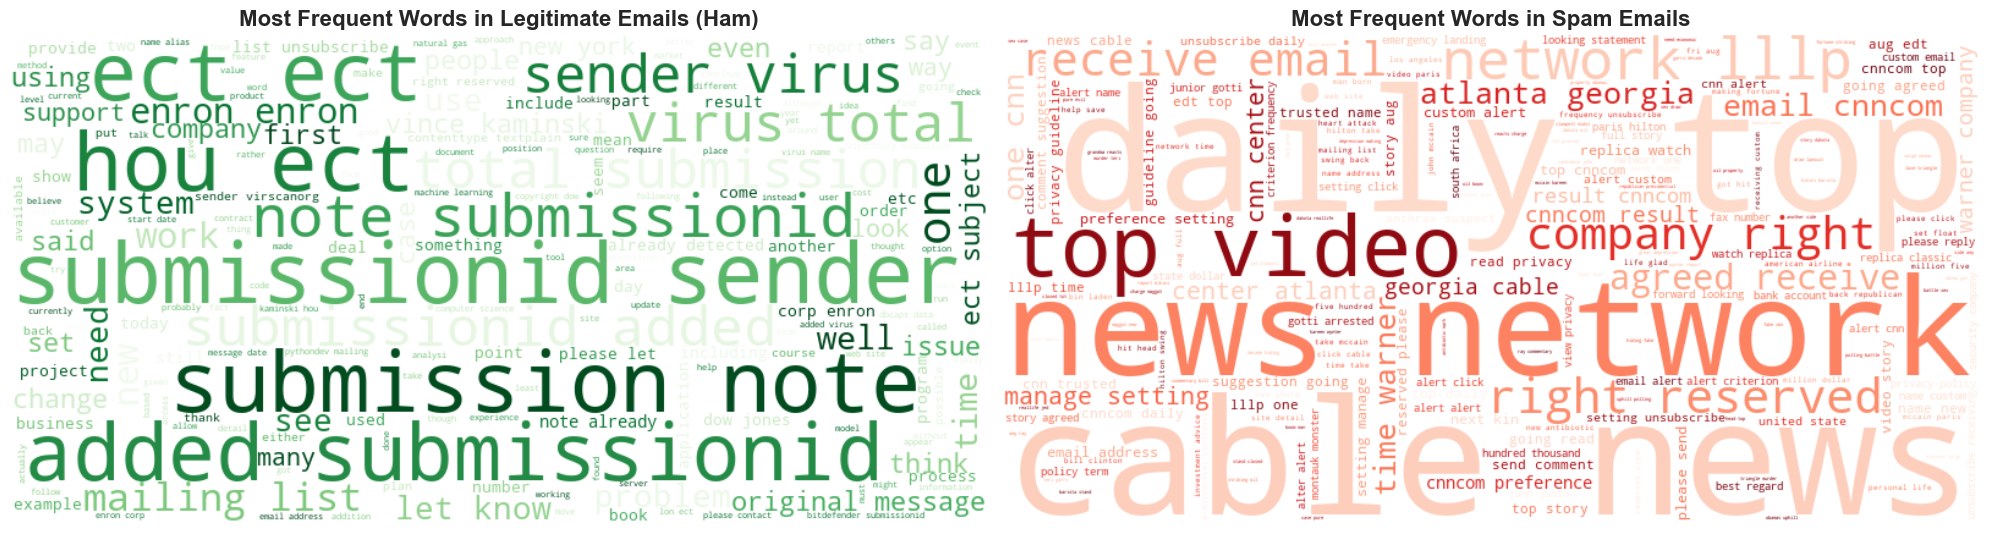

Word cloud generation function created!


In [6]:
# =============================================================================
# PART 6: WORD CLOUDS AND VISUALIZATION
# =============================================================================

print("\n" + "="*80)
print("PART 6: TEXT VISUALIZATION")
print("="*80)

def generate_wordclouds(df):
    """
    Generate word clouds for spam and ham emails
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with cleaned text and labels
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Ham emails word cloud
    ham_text = ' '.join(df[df['label']==0]['full_text'])
    ham_wordcloud = WordCloud(width=800, height=400, 
                              background_color='white',
                              colormap='Greens').generate(ham_text)
    
    axes[0].imshow(ham_wordcloud, interpolation='bilinear')
    axes[0].set_title('Most Frequent Words in Legitimate Emails (Ham)', 
                     fontsize=16, fontweight='bold')
    axes[0].axis('off')
    
    # Spam emails word cloud
    spam_text = ' '.join(df[df['label']==1]['full_text'])
    spam_wordcloud = WordCloud(width=800, height=400,
                               background_color='white',
                               colormap='Reds').generate(spam_text)
    
    axes[1].imshow(spam_wordcloud, interpolation='bilinear')
    axes[1].set_title('Most Frequent Words in Spam Emails', 
                     fontsize=16, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('wordclouds.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
generate_wordclouds(df)

print("Word cloud generation function created!")

In [7]:
# =============================================================================
# PART 7: TRAIN-TEST SPLIT AND TF-IDF VECTORIZATION
# =============================================================================

print("\n" + "="*80)
print("PART 7: DATA PREPARATION FOR MODELING")
print("="*80)

def prepare_data_for_modeling(df, test_size=0.2, random_state=42):
    """
    Prepare data for machine learning models
    
    Parameters:
    -----------
    df : pd.DataFrame
        Preprocessed DataFrame
    test_size : float
        Proportion of data for testing
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple
        X_train, X_test, y_train, y_test, vectorizer, feature_names
    """
    print("Preparing data for modeling...")
    
    # Separate features and target
    X = df['full_text']
    y = df['label']
    
    print(f"\nTotal samples: {len(X)}")
    print(f"Spam samples: {sum(y==1)} ({(sum(y==1)/len(y))*100:.2f}%)")
    print(f"Ham samples: {sum(y==0)} ({(sum(y==0)/len(y))*100:.2f}%)")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"\nTraining samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    
    # TF-IDF Vectorization
    print("\nApplying TF-IDF vectorization...")
    vectorizer = TfidfVectorizer(
        max_features=3000,  # Limit to top 3000 features
        min_df=2,           # Minimum document frequency
        max_df=0.8,         # Maximum document frequency
        ngram_range=(1, 2)  # Unigrams and bigrams
    )
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
    print(f"Number of features: {X_train_tfidf.shape[1]}")
    
    feature_names = vectorizer.get_feature_names_out()
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test, vectorizer, feature_names

# Example usage:
X_train, X_test, y_train, y_test, vectorizer, feature_names = prepare_data_for_modeling(df)

print("\nData preparation function created!")
print("Features:")
print("- Train-test split (80-20)")
print("- TF-IDF vectorization")
print("- Bigram support")
print("- Feature selection (top 3000)")


PART 7: DATA PREPARATION FOR MODELING
Preparing data for modeling...

Total samples: 82486
Spam samples: 42891 (52.00%)
Ham samples: 39595 (48.00%)

Training samples: 65988
Testing samples: 16498

Applying TF-IDF vectorization...
TF-IDF matrix shape: (65988, 3000)
Number of features: 3000

Data preparation function created!
Features:
- Train-test split (80-20)
- TF-IDF vectorization
- Bigram support
- Feature selection (top 3000)


In [8]:
# =============================================================================
# PART 8: MODEL TRAINING - NAIVE BAYES
# =============================================================================

print("\n" + "="*80)
print("PART 8: MODEL 1 - NAIVE BAYES CLASSIFIER")
print("="*80)

def train_naive_bayes(X_train, X_test, y_train, y_test):
    """
    Train and evaluate Naive Bayes classifier
    
    Parameters:
    -----------
    X_train, X_test : sparse matrix
        Training and testing features
    y_train, y_test : array
        Training and testing labels
        
    Returns:
    --------
    tuple
        model, predictions, metrics
    """
    print("Training Naive Bayes Classifier...")
    
    # Initialize and train model
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = nb_model.predict(X_test)
    y_pred_proba = nb_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print("\nNaive Bayes Results:")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1_score']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    return nb_model, y_pred, metrics

# Example usage:
nb_model, nb_pred, nb_metrics = train_naive_bayes(X_train, X_test, y_train, y_test)

print("\nNaive Bayes model training function created!")


PART 8: MODEL 1 - NAIVE BAYES CLASSIFIER
Training Naive Bayes Classifier...

Naive Bayes Results:
Accuracy:  0.9390
Precision: 0.9777
Recall:    0.9034
F1-Score:  0.9391
ROC-AUC:   0.9912

Confusion Matrix:
[[7742  177]
 [ 829 7750]]

Naive Bayes model training function created!


In [9]:
# =============================================================================
# PART 9: MODEL TRAINING - SUPPORT VECTOR MACHINE
# =============================================================================

print("\n" + "="*80)
print("PART 9: MODEL 2 - SUPPORT VECTOR MACHINE")
print("="*80)

def train_svm(X_train, X_test, y_train, y_test):
    """
    Train and evaluate SVM classifier
    
    Parameters:
    -----------
    X_train, X_test : sparse matrix
        Training and testing features
    y_train, y_test : array
        Training and testing labels
        
    Returns:
    --------
    tuple
        model, predictions, metrics
    """
    print("Training Support Vector Machine...")
    
    # Initialize and train model with linear kernel
    svm_model = SVC(kernel='linear', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = svm_model.predict(X_test)
    y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print("\nSVM Results:")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1_score']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    return svm_model, y_pred, metrics

# Example usage:
svm_model, svm_pred, svm_metrics = train_svm(X_train, X_test, y_train, y_test)

print("\nSVM model training function created!")


PART 9: MODEL 2 - SUPPORT VECTOR MACHINE
Training Support Vector Machine...

SVM Results:
Accuracy:  0.9779
Precision: 0.9756
Recall:    0.9822
F1-Score:  0.9789
ROC-AUC:   0.9964

Confusion Matrix:
[[7708  211]
 [ 153 8426]]

SVM model training function created!


In [10]:
# =============================================================================
# PART 10: MODEL TRAINING - LOGISTIC REGRESSION
# =============================================================================

print("\n" + "="*80)
print("PART 10: MODEL 3 - LOGISTIC REGRESSION")
print("="*80)

def train_logistic_regression(X_train, X_test, y_train, y_test):
    """
    Train and evaluate Logistic Regression classifier
    
    Parameters:
    -----------
    X_train, X_test : sparse matrix
        Training and testing features
    y_train, y_test : array
        Training and testing labels
        
    Returns:
    --------
    tuple
        model, predictions, metrics
    """
    print("Training Logistic Regression...")
    
    # Initialize and train model
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = lr_model.predict(X_test)
    y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print("\nLogistic Regression Results:")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1_score']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    return lr_model, y_pred, metrics

# Example usage:
lr_model, lr_pred, lr_metrics = train_logistic_regression(X_train, X_test, y_train, y_test)

print("\nLogistic Regression model training function created!")


PART 10: MODEL 3 - LOGISTIC REGRESSION
Training Logistic Regression...

Logistic Regression Results:
Accuracy:  0.9763
Precision: 0.9744
Recall:    0.9802
F1-Score:  0.9773
ROC-AUC:   0.9968

Confusion Matrix:
[[7698  221]
 [ 170 8409]]

Logistic Regression model training function created!


In [11]:
# =============================================================================
# PART 11: MODEL TRAINING - RANDOM FOREST
# =============================================================================

print("\n" + "="*80)
print("PART 11: MODEL 4 - RANDOM FOREST CLASSIFIER")
print("="*80)

def train_random_forest(X_train, X_test, y_train, y_test):
    """
    Train and evaluate Random Forest classifier
    
    Parameters:
    -----------
    X_train, X_test : sparse matrix
        Training and testing features
    y_train, y_test : array
        Training and testing labels
        
    Returns:
    --------
    tuple
        model, predictions, metrics
    """
    print("Training Random Forest Classifier...")
    
    # Initialize and train model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print("\nRandom Forest Results:")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1_score']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Feature importance (top 20)
    if hasattr(rf_model, 'feature_importances_'):
        print("\nCalculating feature importances...")
    
    return rf_model, y_pred, metrics

# Example usage:
rf_model, rf_pred, rf_metrics = train_random_forest(X_train, X_test, y_train, y_test)

print("\nRandom Forest model training function created!")

print("\n" + "="*80)
print("ALL MODEL TRAINING FUNCTIONS CREATED!")
print("="*80)
print("\nModels included:")
print("1. Naive Bayes Classifier")
print("2. Support Vector Machine (Linear kernel)")
print("3. Logistic Regression")
print("4. Random Forest Classifier")


PART 11: MODEL 4 - RANDOM FOREST CLASSIFIER
Training Random Forest Classifier...

Random Forest Results:
Accuracy:  0.9784
Precision: 0.9832
Recall:    0.9752
F1-Score:  0.9792
ROC-AUC:   0.9973

Confusion Matrix:
[[7776  143]
 [ 213 8366]]

Calculating feature importances...

Random Forest model training function created!

ALL MODEL TRAINING FUNCTIONS CREATED!

Models included:
1. Naive Bayes Classifier
2. Support Vector Machine (Linear kernel)
3. Logistic Regression
4. Random Forest Classifier


PART 12: MODEL COMPARISON

MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
        Naive Bayes  0.939023   0.977671 0.903369  0.939052 0.991214
                SVM  0.977937   0.975570 0.982166  0.978857 0.996443
Logistic Regression  0.976300   0.974392 0.980184  0.977279 0.996753
      Random Forest  0.978422   0.983194 0.975172  0.979167 0.997296

BEST MODELS BY METRIC
Accuracy    : Random Forest        (0.9784)
Precision   : Random Forest        (0.9832)
Recall      : SVM                  (0.9822)
F1-Score    : Random Forest        (0.9792)
ROC-AUC     : Random Forest        (0.9973)


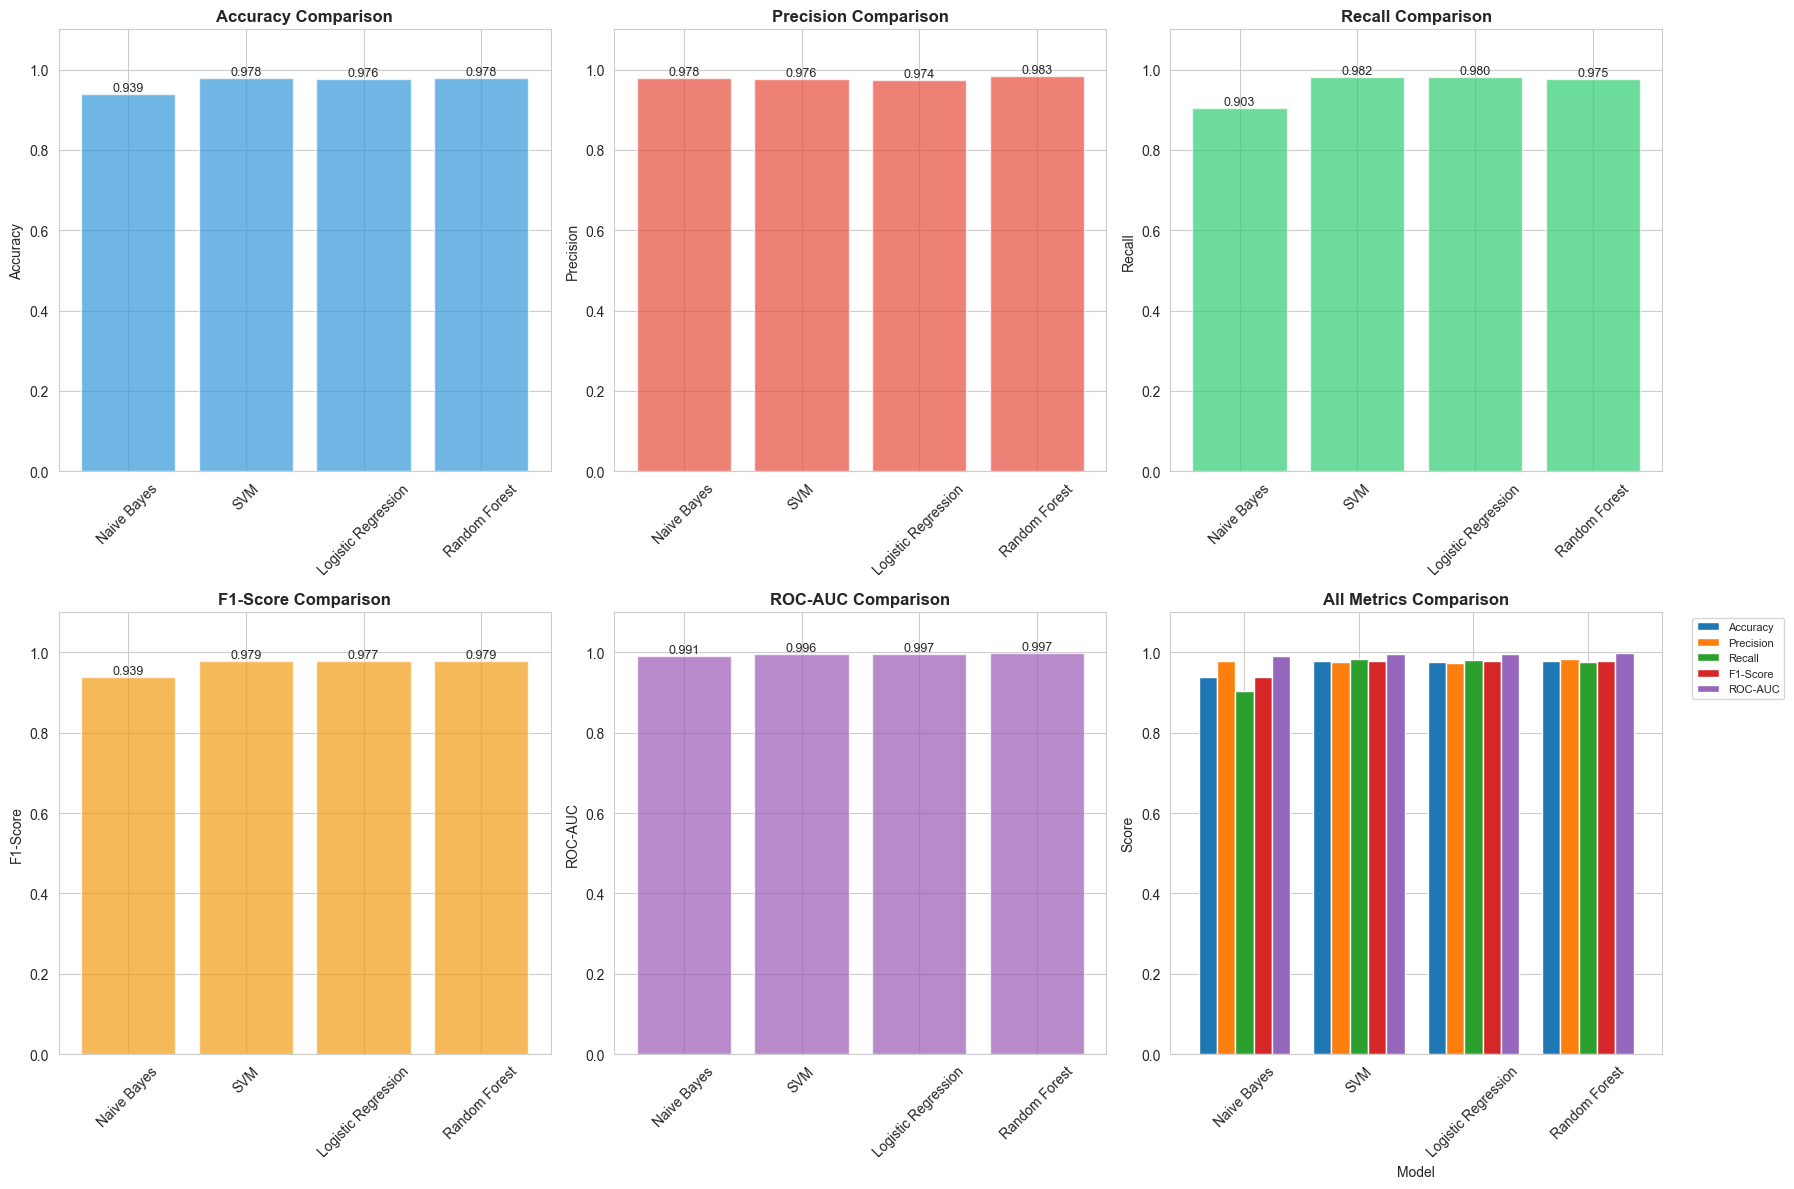


Model comparison function created!


In [12]:
# =============================================================================
# PART 12: MODEL COMPARISON AND VISUALIZATION
# =============================================================================

print("="*80)
print("PART 12: MODEL COMPARISON")
print("="*80)

def compare_models(models_dict, y_test):
    """
    Compare multiple models and visualize results
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and (model, predictions, metrics) as values
    y_test : array
        True labels
    """
    # Create comparison DataFrame
    comparison_data = []
    
    for model_name, (model, y_pred, metrics) in models_dict.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1_score'],
            'ROC-AUC': metrics['roc_auc']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(comparison_df.to_string(index=False))
    
    # Find best model for each metric
    print("\n" + "="*80)
    print("BEST MODELS BY METRIC")
    print("="*80)
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
        best_idx = comparison_df[metric].idxmax()
        best_model = comparison_df.loc[best_idx, 'Model']
        best_score = comparison_df.loc[best_idx, metric]
        print(f"{metric:12s}: {best_model:20s} ({best_score:.4f})")
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    # Plot individual metrics
    for idx, metric in enumerate(metrics_to_plot):
        row = idx // 3
        col = idx % 3
        
        ax = axes[row, col]
        bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[idx], alpha=0.7)
        ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric)
        ax.set_ylim([0, 1.1])
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    # Overall comparison
    ax = axes[1, 2]
    comparison_df.set_index('Model')[metrics_to_plot].plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1.1])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return comparison_df

# Example usage:

models_dict = {
    'Naive Bayes': (nb_model, nb_pred, nb_metrics),
    'SVM': (svm_model, svm_pred, svm_metrics),
    'Logistic Regression': (lr_model, lr_pred, lr_metrics),
    'Random Forest': (rf_model, rf_pred, rf_metrics)
}
comparison_df = compare_models(models_dict, y_test)


print("\nModel comparison function created!")


PART 13: CONFUSION MATRICES


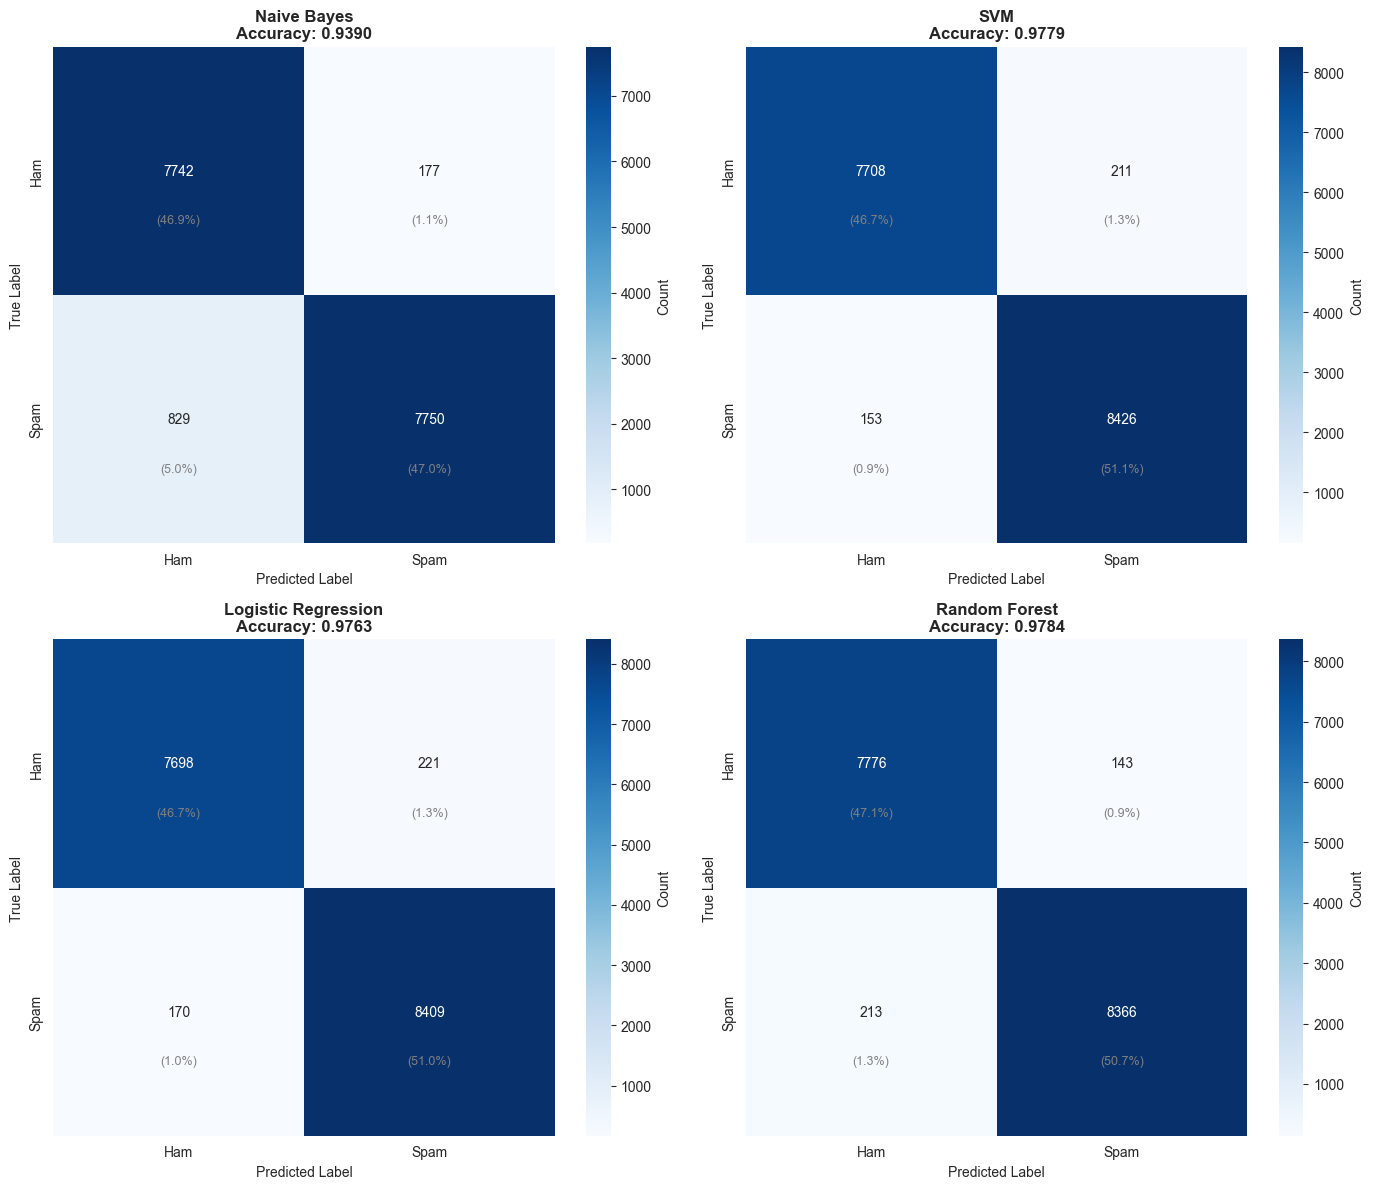

Confusion matrix visualization function created!


In [13]:
# =============================================================================
# PART 13: CONFUSION MATRICES VISUALIZATION
# =============================================================================

print("\n" + "="*80)
print("PART 13: CONFUSION MATRICES")
print("="*80)

def plot_confusion_matrices(models_dict, y_test):
    """
    Plot confusion matrices for all models
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names and predictions
    y_test : array
        True labels
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.ravel()
    
    for idx, (model_name, (model, y_pred, metrics)) in enumerate(models_dict.items()):
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   cbar_kws={'label': 'Count'})
        axes[idx].set_title(f'{model_name}\nAccuracy: {metrics["accuracy"]:.4f}',
                          fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_xticklabels(['Ham', 'Spam'])
        axes[idx].set_yticklabels(['Ham', 'Spam'])
        
        # Add percentages
        total = cm.sum()
        for i in range(2):
            for j in range(2):
                percentage = (cm[i, j] / total) * 100
                axes[idx].text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                             ha='center', va='center', fontsize=9, color='gray')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_confusion_matrices(models_dict, y_test)

print("Confusion matrix visualization function created!")


PART 14: ROC CURVES


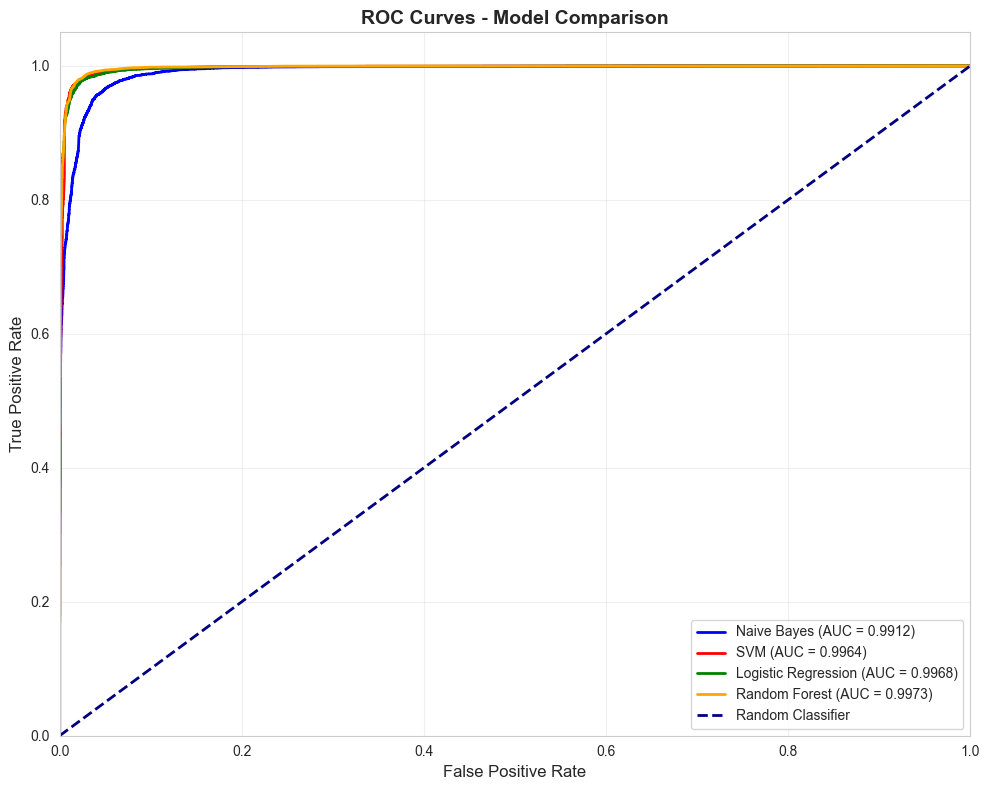

ROC curve visualization function created!


In [14]:
# =============================================================================
# PART 14: ROC CURVES
# =============================================================================

print("\n" + "="*80)
print("PART 14: ROC CURVES")
print("="*80)

def plot_roc_curves(models_dict, X_test, y_test):
    """
    Plot ROC curves for all models
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names and models
    X_test : sparse matrix
        Test features
    y_test : array
        True labels
    """
    plt.figure(figsize=(10, 8))
    
    colors = ['blue', 'red', 'green', 'orange']
    
    for idx, (model_name, (model, y_pred, metrics)) in enumerate(models_dict.items()):
        # Get probability predictions
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test)
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = metrics['roc_auc']
        
        # Plot
        plt.plot(fpr, tpr, color=colors[idx], lw=2, 
                label=f'{model_name} (AUC = {roc_auc:.4f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_roc_curves(models_dict, X_test, y_test)

print("ROC curve visualization function created!")


PART 15: FEATURE IMPORTANCE


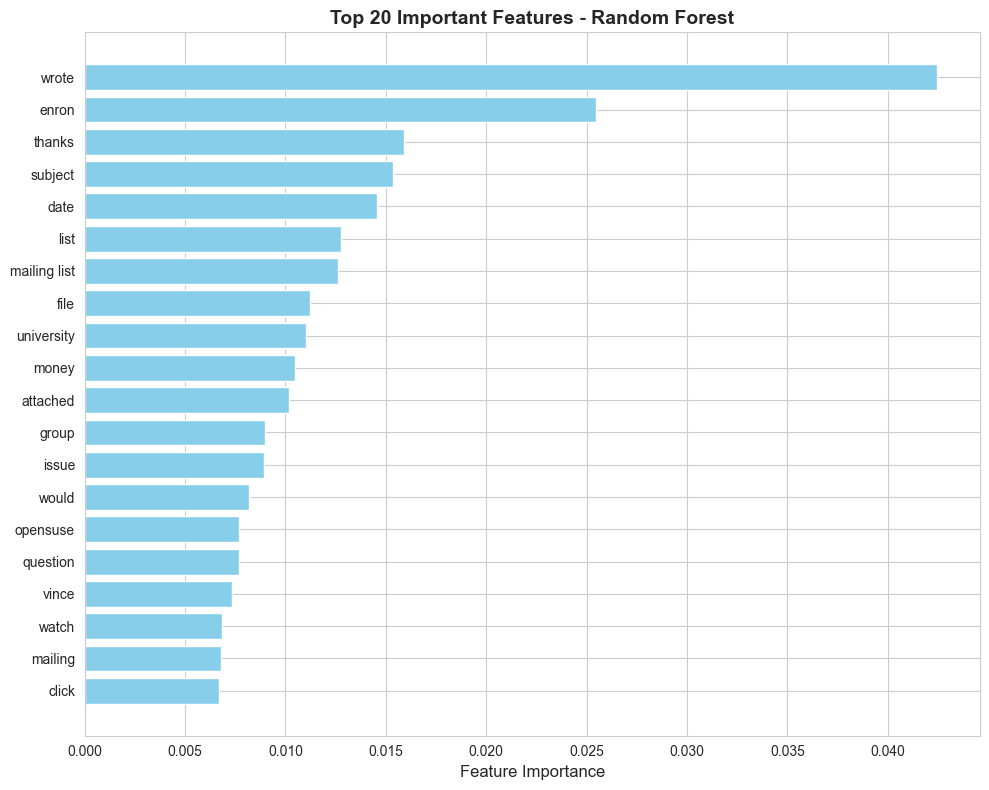

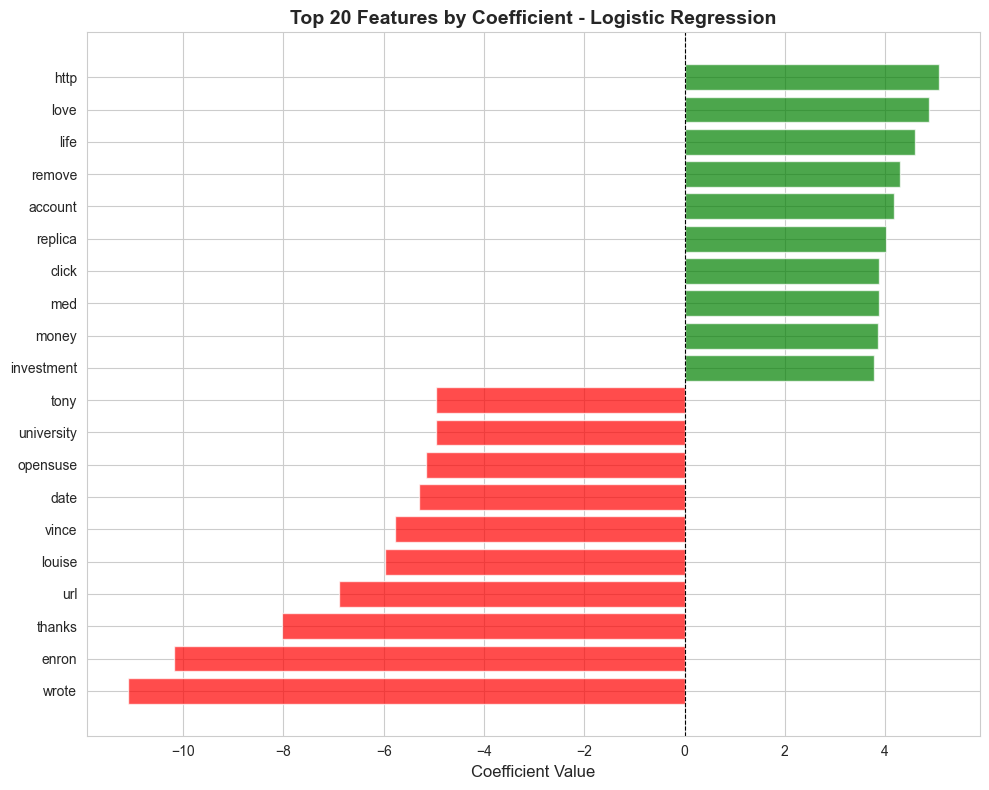

Feature importance visualization function created!


In [15]:
# =============================================================================
# PART 15: FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("PART 15: FEATURE IMPORTANCE")
print("="*80)

def plot_feature_importance(model, feature_names, top_n=20, model_name='Model'):
    """
    Plot feature importance for tree-based models or coefficient-based models
    
    Parameters:
    -----------
    model : sklearn model
        Trained model
    feature_names : array
        Names of features
    top_n : int
        Number of top features to display
    model_name : str
        Name of the model
    """
    plt.figure(figsize=(10, 8))
    
    if hasattr(model, 'feature_importances_'):
        # For tree-based models (Random Forest)
        importances = model.feature_importances_
        indices = np.argsort(importances)[-top_n:]
        
        plt.barh(range(top_n), importances[indices], color='skyblue')
        plt.yticks(range(top_n), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance', fontsize=12)
        plt.title(f'Top {top_n} Important Features - {model_name}', 
                 fontsize=14, fontweight='bold')
        
    elif hasattr(model, 'coef_'):
        # For linear models (Logistic Regression, SVM)
        coefficients = model.coef_[0]
        
        # Get top positive and negative coefficients
        top_positive_idx = np.argsort(coefficients)[-top_n//2:]
        top_negative_idx = np.argsort(coefficients)[:top_n//2]
        
        top_features = np.concatenate([top_negative_idx, top_positive_idx])
        top_coef = coefficients[top_features]
        
        colors = ['red' if c < 0 else 'green' for c in top_coef]
        
        plt.barh(range(len(top_features)), top_coef, color=colors, alpha=0.7)
        plt.yticks(range(len(top_features)), [feature_names[i] for i in top_features])
        plt.xlabel('Coefficient Value', fontsize=12)
        plt.title(f'Top {top_n} Features by Coefficient - {model_name}',
                 fontsize=14, fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    
    plt.tight_layout()
    plt.savefig(f'feature_importance_{model_name.replace(" ", "_")}.png', 
               dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_feature_importance(rf_model, feature_names, top_n=20, model_name='Random Forest')
plot_feature_importance(lr_model, feature_names, top_n=20, model_name='Logistic Regression')

print("Feature importance visualization function created!")

In [16]:
# =============================================================================
# PART 16: HYPERPARAMETER TUNING
# =============================================================================

print("\n" + "="*80)
print("PART 16: HYPERPARAMETER TUNING")
print("="*80)

def tune_random_forest(X_train, y_train):
    """
    Perform hyperparameter tuning for Random Forest
    
    Parameters:
    -----------
    X_train : sparse matrix
        Training features
    y_train : array
        Training labels
        
    Returns:
    --------
    best model
    """
    print("Performing GridSearchCV for Random Forest...")
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestClassifier(random_state=42)
    
    grid_search = GridSearchCV(
        rf, param_grid, cv=3, scoring='f1', 
        n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"\nBest F1-Score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

def tune_logistic_regression(X_train, y_train):
    """
    Perform hyperparameter tuning for Logistic Regression
    
    Parameters:
    -----------
    X_train : sparse matrix
        Training features
    y_train : array
        Training labels
        
    Returns:
    --------
    best model
    """
    print("Performing GridSearchCV for Logistic Regression...")
    
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],  # Changed: Remove 'l1' to avoid saga solver
        'solver': ['liblinear']  # Changed: Only use liblinear (faster and more stable)
    }
    
    lr = LogisticRegression(max_iter=2000, random_state=42)  # Changed: Increased to 2000
    
    grid_search = GridSearchCV(
        lr, param_grid, cv=3, scoring='f1',
        n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"\nBest F1-Score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Example usage:
best_rf = tune_random_forest(X_train, y_train)
best_lr = tune_logistic_regression(X_train, y_train)

print("Hyperparameter tuning functions created!")


PART 16: HYPERPARAMETER TUNING
Performing GridSearchCV for Random Forest...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best parameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Best F1-Score: 0.9770
Performing GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters found:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Best F1-Score: 0.9761
Hyperparameter tuning functions created!



PART 17: CROSS-VALIDATION
Performing 3-Fold Cross-Validation...

Evaluating Naive Bayes...
Accuracy: 0.9370 (+/- 0.0002)
F1-Score: 0.9370 (+/- 0.0002)

Evaluating SVM...
Accuracy: 0.9746 (+/- 0.0011)
F1-Score: 0.9757 (+/- 0.0011)

Evaluating Logistic Regression...
Accuracy: 0.9738 (+/- 0.0012)
F1-Score: 0.9749 (+/- 0.0011)

Evaluating Random Forest...
Accuracy: 0.9752 (+/- 0.0005)
F1-Score: 0.9761 (+/- 0.0005)

CROSS-VALIDATION RESULTS
              Model  Accuracy Mean  Accuracy Std  F1-Score Mean  F1-Score Std
        Naive Bayes       0.937004      0.000190       0.936980      0.000224
                SVM       0.974632      0.001136       0.975747      0.001063
Logistic Regression       0.973768      0.001179       0.974920      0.001104
      Random Forest       0.975238      0.000467       0.976129      0.000451


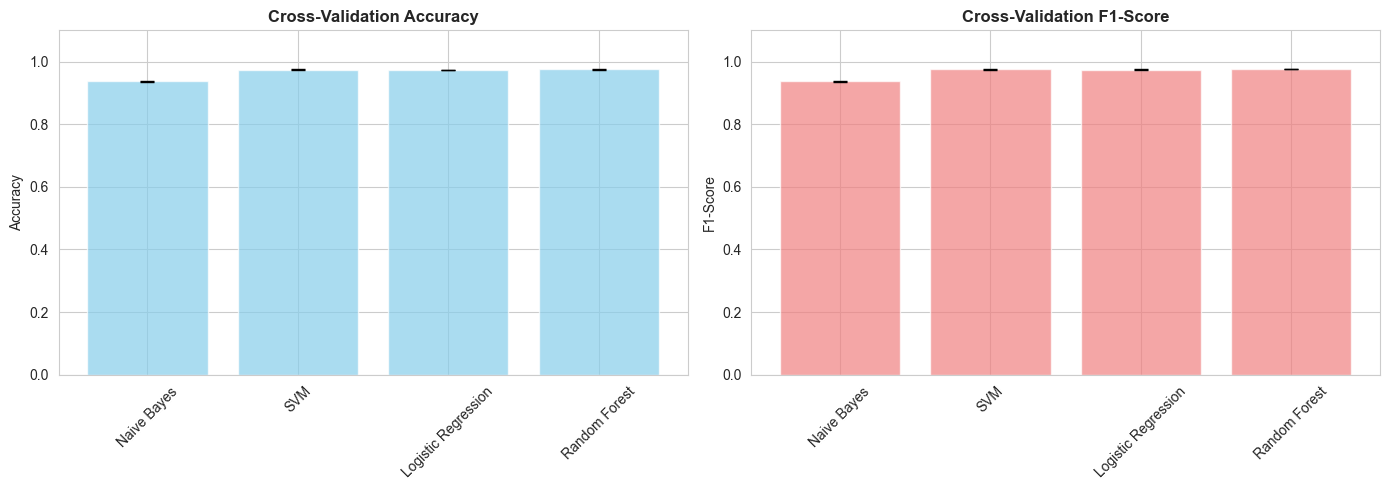

Cross-validation function created!


In [17]:
# =============================================================================
# PART 17: CROSS-VALIDATION
# =============================================================================

print("\n" + "="*80)
print("PART 17: CROSS-VALIDATION")
print("="*80)

def perform_cross_validation(models_dict, X_train, y_train, cv=3):
    """
    Perform k-fold cross-validation for all models
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary of models
    X_train : sparse matrix
        Training features
    y_train : array
        Training labels
    cv : int
        Number of folds
    """
    print(f"Performing {cv}-Fold Cross-Validation...")
    
    cv_results = []
    
    for model_name, (model, _, _) in models_dict.items():
        print(f"\nEvaluating {model_name}...")
        
        # Accuracy
        acc_scores = cross_val_score(model, X_train, y_train, 
                                     cv=cv, scoring='accuracy', n_jobs=-1)
        
        # F1-Score
        f1_scores = cross_val_score(model, X_train, y_train,
                                    cv=cv, scoring='f1', n_jobs=-1)
        
        cv_results.append({
            'Model': model_name,
            'Accuracy Mean': acc_scores.mean(),
            'Accuracy Std': acc_scores.std(),
            'F1-Score Mean': f1_scores.mean(),
            'F1-Score Std': f1_scores.std()
        })
        
        print(f"Accuracy: {acc_scores.mean():.4f} (+/- {acc_scores.std():.4f})")
        print(f"F1-Score: {f1_scores.mean():.4f} (+/- {f1_scores.std():.4f})")
    
    cv_df = pd.DataFrame(cv_results)
    
    print("\n" + "="*80)
    print("CROSS-VALIDATION RESULTS")
    print("="*80)
    print(cv_df.to_string(index=False))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].bar(cv_df['Model'], cv_df['Accuracy Mean'], 
               yerr=cv_df['Accuracy Std'], capsize=5, color='skyblue', alpha=0.7)
    axes[0].set_title('Cross-Validation Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim([0, 1.1])
    axes[0].tick_params(axis='x', rotation=45)
    
    # F1-Score
    axes[1].bar(cv_df['Model'], cv_df['F1-Score Mean'],
               yerr=cv_df['F1-Score Std'], capsize=5, color='lightcoral', alpha=0.7)
    axes[1].set_title('Cross-Validation F1-Score', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('F1-Score')
    axes[1].set_ylim([0, 1.1])
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('cross_validation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cv_df

# Example usage
cv_results = perform_cross_validation(models_dict, X_train, y_train, cv=3)

print("Cross-validation function created!")

In [18]:
# =============================================================================
# PART 17.5: PREPARE FOR ERROR ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("PART 17.5: PREPARING FOR ERROR ANALYSIS")
print("="*80)

# Find best model based on F1-Score
comparison_data = []
for model_name, (model, y_pred, metrics) in models_dict.items():
    comparison_data.append({
        'Model': model_name,
        'F1-Score': metrics['f1_score'],
        'Accuracy': metrics['accuracy']
    })

comparison_df_temp = pd.DataFrame(comparison_data)
best_model_name = comparison_df_temp.loc[comparison_df_temp['F1-Score'].idxmax(), 'Model']
best_model = models_dict[best_model_name][0]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {comparison_df_temp['F1-Score'].max():.4f}")
print(f"   Accuracy: {comparison_df_temp.loc[comparison_df_temp['F1-Score'].idxmax(), 'Accuracy']:.4f}")

# Get original test emails for error analysis
# We need to retrieve the original text from the dataframe
test_indices = y_test.index
X_test_original = df.loc[test_indices, 'body'].values

print(f"\n✓ Retrieved {len(X_test_original)} original test emails")
print(f"✓ Best model selected: {best_model_name}")


PART 17.5: PREPARING FOR ERROR ANALYSIS

🏆 Best Model: Random Forest
   F1-Score: 0.9792
   Accuracy: 0.9784

✓ Retrieved 16498 original test emails
✓ Best model selected: Random Forest


In [19]:
# =============================================================================
# PART 18: ERROR ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("PART 18: ERROR ANALYSIS")
print("="*80)

def analyze_errors(model, X_test, y_test, original_texts, model_name='Model'):
    """
    Analyze misclassified examples
    
    Parameters:
    -----------
    model : sklearn model
        Trained model
    X_test : sparse matrix
        Test features
    y_test : array
        True labels
    original_texts : array
        Original email texts
    model_name : str
        Name of the model
    """
    y_pred = model.predict(X_test)
    
    # Find misclassified examples
    misclassified_idx = np.where(y_pred != y_test.values)[0]
    
    print(f"\n{'='*60}")
    print(f"{model_name} - ERROR ANALYSIS")
    print(f"{'='*60}")
    
    print(f"\nTotal Test Emails: {len(y_test)}")
    print(f"Correctly Classified: {len(y_test) - len(misclassified_idx)} ({((len(y_test)-len(misclassified_idx))/len(y_test))*100:.2f}%)")
    print(f"Misclassified: {len(misclassified_idx)} ({(len(misclassified_idx)/len(y_test))*100:.2f}%)")
    
    # False Positives (Ham predicted as Spam)
    fp_idx = np.where((y_pred == 1) & (y_test.values == 0))[0]
    print(f"\n{'─'*60}")
    print(f"False Positives (Legitimate emails marked as Spam): {len(fp_idx)}")
    print(f"  Impact: {len(fp_idx)} important emails might go to spam folder")
    
    # False Negatives (Spam predicted as Ham)
    fn_idx = np.where((y_pred == 0) & (y_test.values == 1))[0]
    print(f"\nFalse Negatives (Spam emails marked as Legitimate): {len(fn_idx)}")
    print(f"  Impact: {len(fn_idx)} spam emails would reach the inbox")
    
    # Show example errors
    if len(fp_idx) > 0:
        print(f"\n{'─'*60}")
        print("SAMPLE FALSE POSITIVES (Legitimate emails incorrectly marked as spam):")
        print(f"{'─'*60}")
        for i, idx in enumerate(fp_idx[:3]):
            print(f"\nExample {i+1}:")
            email_text = str(original_texts[idx])[:300]
            print(f"Email Preview: {email_text}...")
            print(f"True Label: HAM (Legitimate)")
            print(f"Predicted: SPAM ✗")
            print(f"{'-'*60}")
    else:
        print("\n✓ No false positives found!")
    
    if len(fn_idx) > 0:
        print(f"\n{'─'*60}")
        print("SAMPLE FALSE NEGATIVES (Spam emails incorrectly marked as legitimate):")
        print(f"{'─'*60}")
        for i, idx in enumerate(fn_idx[:3]):
            print(f"\nExample {i+1}:")
            email_text = str(original_texts[idx])[:300]
            print(f"Email Preview: {email_text}...")
            print(f"True Label: SPAM")
            print(f"Predicted: HAM (Legitimate) ✗")
            print(f"{'-'*60}")
    else:
        print("\n✓ No false negatives found!")
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("ERROR BREAKDOWN")
    print(f"{'='*60}")
    total_errors = len(misclassified_idx)
    if total_errors > 0:
        print(f"Total Errors: {total_errors}")
        print(f"  • False Positives: {len(fp_idx)} ({len(fp_idx)/total_errors*100:.1f}% of errors)")
        print(f"  • False Negatives: {len(fn_idx)} ({len(fn_idx)/total_errors*100:.1f}% of errors)")
        
        # Which error is worse?
        if len(fp_idx) > len(fn_idx):
            print(f"\n⚠️  Model tends to be OVER-CAUTIOUS (more false positives)")
            print(f"    May block legitimate emails")
        elif len(fn_idx) > len(fp_idx):
            print(f"\n⚠️  Model tends to be UNDER-CAUTIOUS (more false negatives)")
            print(f"    May allow spam through")
        else:
            print(f"\n✓ Balanced error distribution")
    else:
        print("✓ Perfect classification - No errors!")
    
    print(f"{'='*60}")
    
    return misclassified_idx, fp_idx, fn_idx

# Perform error analysis
print("\nPerforming error analysis on best model...")
misclass, fp, fn = analyze_errors(best_model, X_test, y_test, X_test_original, best_model_name)

print("\n✓ Error analysis completed!")


PART 18: ERROR ANALYSIS

Performing error analysis on best model...

Random Forest - ERROR ANALYSIS

Total Test Emails: 16498
Correctly Classified: 16142 (97.84%)
Misclassified: 356 (2.16%)

────────────────────────────────────────────────────────────
False Positives (Legitimate emails marked as Spam): 143
  Impact: 143 important emails might go to spam folder

False Negatives (Spam emails marked as Legitimate): 213
  Impact: 213 spam emails would reach the inbox

────────────────────────────────────────────────────────────
SAMPLE FALSE POSITIVES (Legitimate emails incorrectly marked as spam):
────────────────────────────────────────────────────────────

Example 1:
Email Preview: Five New HD Image Collections

Forward this to a friend
[http://oi.verticalresponse.com/f2af/v4/send_to_friend.html?ch=9da76b50af&lid=1406000320&ldh=06d972dddd]

[http://cts.vresp.com/c/?GalleryPlayer/9da76b50af/06d972dddd/1c9b286635/utm_source=gpinternal&utm_medium=email&utm_content=email-gp-home&u...
True L

In [20]:
# =============================================================================
# PART 19: PREDICTION FUNCTION
# =============================================================================

print("\n" + "="*80)
print("PART 19: EMAIL PREDICTION FUNCTION")
print("="*80)

def predict_email(email_text, model, vectorizer, preprocessor):
    """
    Predict if a single email is spam or ham
    
    Parameters:
    -----------
    email_text : str
        Raw email text
    model : sklearn model
        Trained model
    vectorizer : TfidfVectorizer
        Fitted vectorizer
    preprocessor : TextPreprocessor
        Text preprocessing object
        
    Returns:
    --------
    tuple
        (prediction, probability, label)
    """
    # Preprocess text
    cleaned_text = preprocessor.clean_text(email_text)
    
    # Vectorize
    text_vector = vectorizer.transform([cleaned_text])
    
    # Predict
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0]
    
    label = 'SPAM' if prediction == 1 else 'HAM (Legitimate)'
    confidence = probability[prediction] * 100
    
    print("\n" + "="*60)
    print("EMAIL CLASSIFICATION RESULT")
    print("="*60)
    print(f"Email Text: {email_text[:100]}...")
    print(f"\nPrediction: {label}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Spam Probability: {probability[1]*100:.2f}%")
    print(f"Ham Probability: {probability[0]*100:.2f}%")
    print("="*60)
    
    return prediction, probability, label

# Example usage:

test_email = "Congratulations! You've won $1,000,000! Click here now to claim your prize!"
predict_email(test_email, best_model, vectorizer, preprocessor)


print("Email prediction function created!")


PART 19: EMAIL PREDICTION FUNCTION

EMAIL CLASSIFICATION RESULT
Email Text: Congratulations! You've won $1,000,000! Click here now to claim your prize!...

Prediction: SPAM
Confidence: 79.00%
Spam Probability: 79.00%
Ham Probability: 21.00%
Email prediction function created!


In [21]:
# =============================================================================
# PART 20: SAVE MODEL
# =============================================================================

print("\n" + "="*80)
print("PART 20: MODEL SAVING")
print("="*80)

import pickle

def save_model(model, vectorizer, preprocessor, filename='spam_detector.pkl'):
    """
    Save trained model, vectorizer, and preprocessor
    
    Parameters:
    -----------
    model : sklearn model
        Trained model
    vectorizer : TfidfVectorizer
        Fitted vectorizer
    preprocessor : TextPreprocessor
        Preprocessor object
    filename : str
        Output filename
    """
    model_data = {
        'model': model,
        'vectorizer': vectorizer,
        'preprocessor': preprocessor
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"\nModel saved successfully to {filename}")

def load_model(filename='spam_detector.pkl'):
    """
    Load saved model
    
    Parameters:
    -----------
    filename : str
        Model filename
        
    Returns:
    --------
    tuple
        (model, vectorizer, preprocessor)
    """
    with open(filename, 'rb') as f:
        model_data = pickle.load(f)
    
    print(f"\nModel loaded successfully from {filename}")
    
    return model_data['model'], model_data['vectorizer'], model_data['preprocessor']

# Example usage:
save_model(best_model, vectorizer, preprocessor, 'best_spam_detector.pkl')
loaded_model, loaded_vectorizer, loaded_preprocessor = load_model('best_spam_detector.pkl')

print("Model saving/loading functions created!")

print("\n" + "="*80)
print("PROJECT IMPLEMENTATION COMPLETE!")
print("="*80)


PART 20: MODEL SAVING

Model saved successfully to best_spam_detector.pkl

Model loaded successfully from best_spam_detector.pkl
Model saving/loading functions created!

PROJECT IMPLEMENTATION COMPLETE!
